In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine, MetaData, func
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Numeric, Text, Float
import pandas as pd
import os
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
# Import Matplot lib
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
# Store filepath in a variable
file_one = os.path.join("Resources", "cleaned_hawaii_measurements.csv")
file_two = os.path.join("Resources", "hawaii_stations.csv")
# Read our Data file with the pandas library
# Not every CSV requires an encoding, but be aware this can come up
hawaii_measurements_df = pd.read_csv(file_one, encoding="ISO-8859-1")
hawaii_stations_df = pd.read_csv(file_two, encoding="ISO-8859-1")

In [30]:
hawaii_measurements_df.head()

,Unnamed: 0,station,date,prcp,tobs
0,0,USC00519397,2010-01-01,0.08,65
1,1,USC00519397,2010-01-02,0.00,63
2,2,USC00519397,2010-01-03,0.00,74
3,3,USC00519397,2010-01-04,0.00,76
4,5,USC00519397,2010-01-07,0.06,70


In [4]:
# Use Orient='records' to create a list of data to write
# to_dict() cleans out DataFrame metadata as well
# http://pandas-docs.github.io/pandas-docs-travis/io.html#orient-options
station_data = hawaii_stations_df.to_dict(orient='records')
measurement_data = hawaii_measurements_df.to_dict(orient='records')

In [5]:
# Create an engine to a SQLite database file called `customers.sqlite`
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# Create a connection to the engine called `conn`
conn = engine.connect()

In [7]:
# Use MetaData from SQLAlchemy to reflect the tables
metadata = MetaData(bind=engine)
metadata.reflect()

In [8]:
# Save the reference to the `customers` table as a variable called `table`
station_table = sqlalchemy.Table('Station', metadata, autoload=True)
measurement_table = sqlalchemy.Table('Measurement', metadata, autoload=True)

In [9]:
# Use `table.delete()` to remove any pre-existing data.
# Note that this is a convenience function so that you can re-run the example code multiple times.
# You would not likely do this step in production.
conn.execute(station_table.delete())
conn.execute(measurement_table.delete())

In [10]:
# Use `table.insert()` to insert the data into the table
# The SQL table is populated during this step
conn.execute(station_table.insert(), station_data)
conn.execute(measurement_table.insert(), measurement_data)

In [11]:
# Test that the insert works by fetching . 
conn.execute("select * from Station limit 5").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [12]:
# Test that the insert works by fetching the first 5 rows. 
conn.execute("select * from Measurement limit 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65),
 (2, 'USC00519397', '2010-01-02', 0.0, 63),
 (3, 'USC00519397', '2010-01-03', 0.0, 74),
 (4, 'USC00519397', '2010-01-04', 0.0, 76),
 (5, 'USC00519397', '2010-01-07', 0.06, 70)]

In [13]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station

In [14]:
# Start a session to query the database
session = Session(engine)

In [39]:
# Query Emojis for `emoji_char`, `emoji_id`, and `score` and save the query into results
year_ago = dt.date.today() - dt.timedelta(days = 365)
# year_ago = "5/6/2015"
measurement_results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

In [40]:
query_date = dt.date.today() - dt.timedelta(days=365)
print(query_date)

2017-05-06


In [41]:
len(measurement_results)

567

In [19]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [31]:
session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= query_date).order_by(Measurement.date).first()

('2017-05-06', 0.0)

In [21]:
# Load the results into a pandas dataframe. Set the index to the `emoji_id`
measurement_results_df = pd.DataFrame(measurement_results, columns=['date', 'prcp'])

measurement_results_df.head()


,date,prcp
0,2017-05-06,0.00
1,2017-05-07,0.00
2,2017-05-08,0.00
3,2017-05-10,0.00
4,2017-05-11,0.01


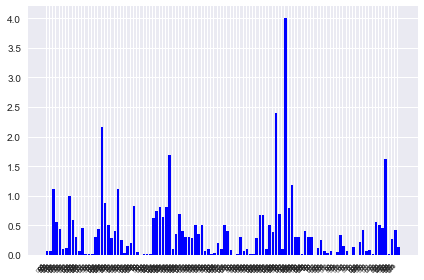

In [22]:
# Create a bar chart based upon the above data
plt.bar(measurement_results_df["date"], measurement_results_df["prcp"], color="b", align="edge")
plt.xticks(measurement_results_df["date"], measurement_results_df["prcp"], rotation=50, horizontalalignment='right', size=5)
plt.tight_layout()

In [23]:
# Total dates
session.query(func.count(Station.name)).all()

[(9)]

In [25]:
# List the stations and observation counts in descending order
session.query(Measurement.station, func.count(Measurement.prcp)).group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [26]:
#  Which station has the highest number of observations?
session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).first()

('USC00519281')

In [28]:
# Load the results into a pandas dataframe. Set the index to the `emoji_id`
last_12_mount_tobs_df = pd.DataFrame(measurement_results, columns=['date', 'tobs'])

In [50]:
last_12_mount_tobs = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == "USC00519281").all()
last_12_mount_tobs_df = pd.DataFrame(last_12_mount_tobs, columns=['station', 'tobs'])
last_12_mount_tobs_df.head()

,station,tobs
0,USC00519281,70
1,USC00519281,62
2,USC00519281,74
3,USC00519281,75
4,USC00519281,74


C:\Users\sinancengiz\Anaconda3\envs\PythonData\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


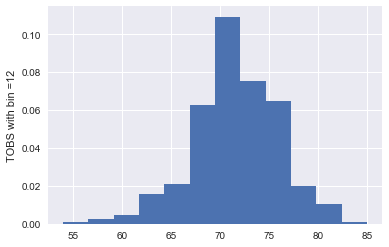

In [58]:
plt.hist(last_12_mount_tobs_df["tobs"], normed=True, bins=12)
plt.ylabel('TOBS with bin =12');

In [ ]:
def calc_temps ()